# Investigate Fitting the $\text{C}\text{O}_2$ NIST Data

In [1]:
import numpy as np
import scipy
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import sciscripttools as st

import utility
import real_gas_law
import co2
import import_data
import plot
import pressure_temperature_constants

# for use in the notebook and for the 3d plots
# for creating a responsive plot
%matplotlib widget

fig_params = st.figure_parameters() # generate parameters
fig_params.brackets = 'square'
st.standard_font(font_size = fig_params.font_size) # standarise the font

# use untill I fix this issue
from matplotlib import rc
rc('text.latex', preamble = r"\usepackage{siunitx} \usepackage{amsmath} \usepackage{bm}" )

## Pxflash Gaw Law Property Equations
These are the equations implemented within pxflash as of 11.2021

In [2]:
def pxflash_c_total(coefficient):
    # no composition change
    return coefficient;


def pxflash_volume(temperature, pressure, compressibility):

    # input pressure in Pa
    pressure_bar = pressure / 100000.0
    
    volume = (compressibility * temperature) / pressure_bar
    
    return volume
    
def pxflash_compressibility(temperature, pressure, volume):
    
     # input pressure in Pa
    pressure_bar = pressure / 100000.0
    
    corrected_compressibility = (pressure_bar * volume) / temperature
    
    return corrected_compressibility
    
# this converts the pxflash volume to the volume used in the actual real gas law
convert_pxflash_volume_to_real_volume = real_gas_law.R / 1e5 

## Prepare Pxflash and NIST Data

### Compute NIST Corrected Compressibility and Corrected Volume
Back-calculate the compressibility and volume from the density.
The use of term 'corrected' is merely in reference to the terms used on the pxflash side, for ease of comparison.

In [3]:
molecular_weight_kg_per_mol = co2.molecular_weight_kg_per_mol

def compute_nist_corrected_compressibility(nist_data):
    
    t, p = nist_data.prepare_temperature_pressure()
    d = nist_data.prepare_density()
    
    z = np.full(len(d), 0.0)
    for i in range(0, len(d)):               
        z[i] = real_gas_law.compressibility_using_denisty(t[i], p[i], molecular_weight_kg_per_mol, d[i])

    nist_corrected_compressibility = z

    return nist_corrected_compressibility

def compute_nist_corrected_volume(nist_data):
    
    t, p = nist_data.prepare_temperature_pressure()
    
    z = compute_nist_corrected_compressibility(nist_data)
    v = np.full(len(z), 0.0)
    
    for i in range(0, len(z)):               
        v[i] = real_gas_law.volume(t[i], p[i], z[i])

    nist_corrected_volume = v
    
    return nist_corrected_volume

### Compute NIST coefficients and Pxflash Cofficients via NIST Densities

In [4]:

# Here `coefficients_liquid_via_nist` and `coefficients_gas_via_nist` are the coefficients 
# required to take the volumes calcualted in `pxflash` to the NIST volumes.
def compute_coefficients_via_nist(pxflash_data, nist_data):

    pxflash_volume_liquid, pxflash_volume_gas = pxflash_data.prepare_volume()
    
    pxflash_volume_liquid_real = pxflash_volume_liquid * convert_pxflash_volume_to_real_volume
    pxflash_volume_gas_real = pxflash_volume_gas * convert_pxflash_volume_to_real_volume
    
    nist_corrected_volume = compute_nist_corrected_volume(nist_data)
    
    coefficients_liquid_via_nist = pxflash_volume_liquid_real - nist_corrected_volume
    coefficients_gas_via_nist = pxflash_volume_gas_real - nist_corrected_volume
    
    return coefficients_liquid_via_nist, coefficients_gas_via_nist

# This function converted the units of the coefficients to the units used in pxflash
def compute_pxflash_units_coefficients_via_nist(pxflash_data, nist_data):
    
    coefficients_liquid_via_nist, coefficients_gas_via_nist = compute_coefficients_via_nist(pxflash_data, nist_data)
    
    coefficients_liquid_via_nist = coefficients_liquid_via_nist / convert_pxflash_volume_to_real_volume
    coefficients_gas_via_nist = coefficients_gas_via_nist /  convert_pxflash_volume_to_real_volume
    
    return coefficients_liquid_via_nist, coefficients_gas_via_nist

## Import Data

In [5]:
nist_data = import_data.NISTData('nist_data.csv')
pxflash_data = import_data.PxFlashData('pxflash_data.csv')

## Compare NIST Volume and NIST 'corrected' volume

[<matplotlib.collections.PathCollection object at 0x0000026A21837640>, <matplotlib.collections.PathCollection object at 0x0000026A21863B50>]


Text(0.5, 0, 'Log Percentage Error')

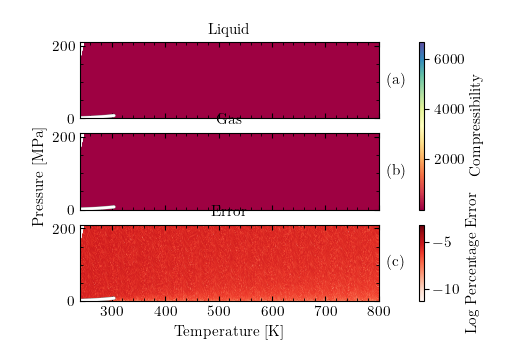

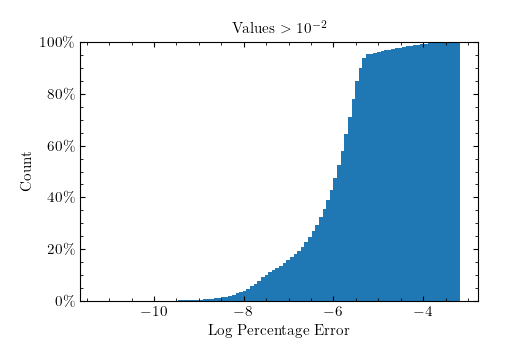

In [6]:
# data
x1, y1 = pxflash_data.prepare_temperature_pressure()
x2 = x1; y2 = y1
z1 = nist_data.prepare_volume() * co2.molecular_weight_kg_per_mol
z2 = compute_nist_corrected_volume(nist_data)


# error
x3 = x1; y3 = y1
error = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x1, y1, error, -16, np.max(error)) 

# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["Liquid", "Gas", "Error"])
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

sf = plot.historgrams([z3], n = len(error))
axes = sf.axes
plot.set_titles(axes,  ["Values $ > 10^{-2}$"])
axes[-1].set_xlabel("Log Percentage Error")

## Compare Pxflash Liquid and Gas Values

### Compressibility

[<matplotlib.collections.PathCollection object at 0x0000026A2281AB60>, <matplotlib.collections.PathCollection object at 0x0000026A227F8670>]


Text(0.5, 0, 'Log Percentage Error')

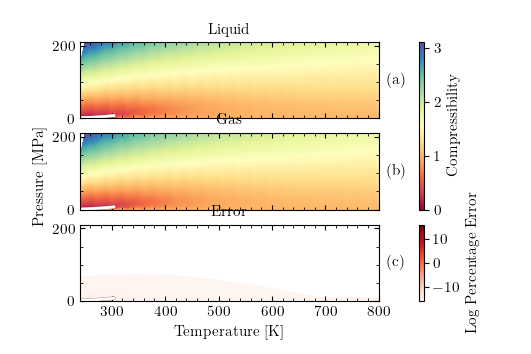

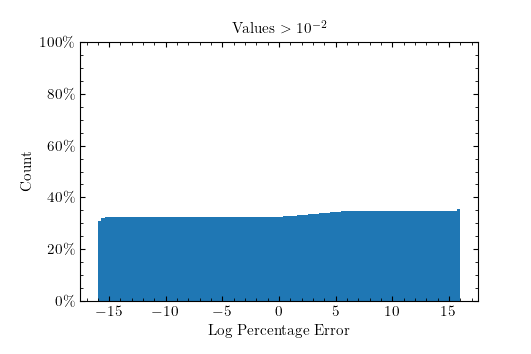

In [7]:
# data
x1, y1 = pxflash_data.prepare_temperature_pressure()
x2 = x1; y2 = y1
z1, z2 = pxflash_data.prepare_compressibility()

# error
x3 = x1; y3 = y1
error = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x1, y1, error, -16, np.max(error)) 

# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["Liquid", "Gas", "Error"])
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

sf = plot.historgrams([z3], n = len(error))
axes = sf.axes
plot.set_titles(axes,  ["Values $ > 10^{-2}$"])
axes[-1].set_xlabel("Log Percentage Error")

### Corrected Compressibility

[<matplotlib.collections.PathCollection object at 0x0000026A227DF5B0>, <matplotlib.collections.PathCollection object at 0x0000026A27828580>]


Text(0.5, 0, 'Log Percentage Error')

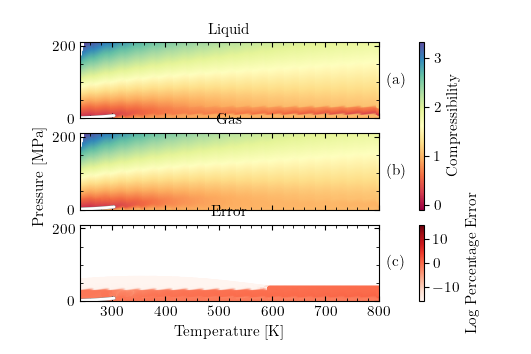

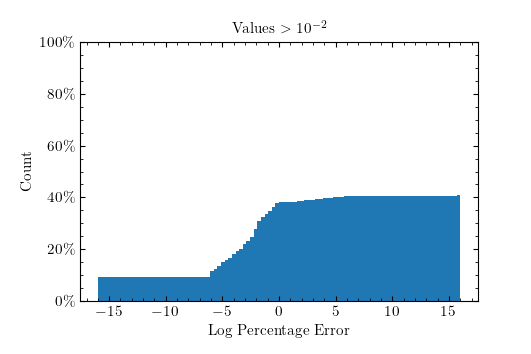

In [8]:
# data
x, y = pxflash_data.prepare_temperature_pressure()
z1, z2 = pxflash_data.prepare_corrected_compressibility()

# error
error = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x, y, error, -16, np.max(error)) 

# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["Liquid", "Gas", "Error"])
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

sf = plot.historgrams([z3], n = len(error))
axes = sf.axes
plot.set_titles(axes,  ["Values $ > 10^{-2}$"])
axes[-1].set_xlabel("Log Percentage Error")

## Compare NIST and Pxflash Corrected Compressibility

Text(0.5, 0, 'Log Percentage Error')

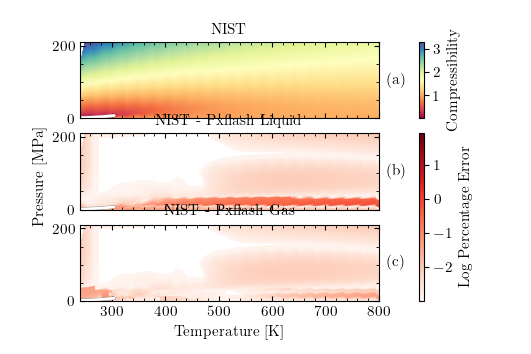

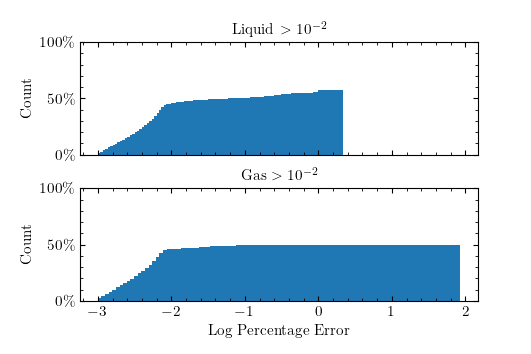

In [9]:
# data
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_compressibility(nist_data)

x2, y2 = pxflash_data.prepare_temperature_pressure()
z_liquid, z_gas = pxflash_data.prepare_corrected_compressibility()

x3 = x2; y3 = y2
# error
z2 = utility.compute_log_percentage_error(z1, z_liquid)
z3 = utility.compute_log_percentage_error(z1, z_gas)

x2, y2, z2 = utility.bound_data(x2, y2, z2, -3, np.max(z2)) 
x3, y3, z3 = utility.bound_data(x3, y3, z3, -3, np.max(z3)) 

# plot
data_normal = [[x1, y1, z1]]
data_error = [[x2, y2, z2], [x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["NIST", "NIST - Pxflash Liquid", "NIST - Pxflash Gas"])
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

sf = plot.historgrams([z2, z3], n = len(z1))
axes = sf.axes
plot.set_titles(axes, ["Liquid $> 10^{-2}$", "Gas $> 10^{-2}$"])
axes[-1].set_xlabel("Log Percentage Error")

## Compare Coefficients

[<matplotlib.collections.PathCollection object at 0x0000026A2AEA0790>, <matplotlib.collections.PathCollection object at 0x0000026A2AEFA8C0>]
[<matplotlib.collections.PathCollection object at 0x0000026A2C289330>, <matplotlib.collections.PathCollection object at 0x0000026A2C2BA920>]


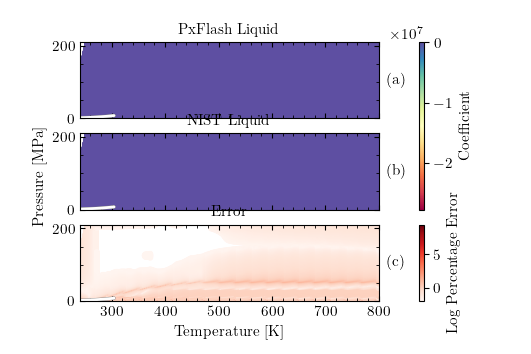

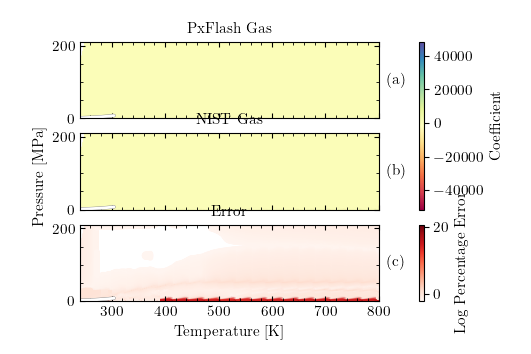

In [10]:
# data
x1, y1 = nist_data.prepare_temperature_pressure()
z1, _ = pxflash_data.prepare_coefficients()
z2, _ = compute_pxflash_units_coefficients_via_nist(pxflash_data, nist_data)

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# error
z3 = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x3, y3, z3, -2, np.max(z3)) 
# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["PxFlash Liquid", "NIST Liquid", "Error"])
plot.set_cbar_labels(cbars, ["Coefficient", "Log Percentage Error"])

# data
x1, y1 = nist_data.prepare_temperature_pressure()
_, z1 = pxflash_data.prepare_coefficients()
_, z2 = compute_pxflash_units_coefficients_via_nist(pxflash_data, nist_data)

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# error
z3 = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x3, y3, z3, -2, np.max(z3)) 
# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes

plot.set_titles(axes, ["PxFlash Gas", "NIST Gas", "Error"])
plot.set_cbar_labels(cbars, ["Coefficient", "Log Percentage Error"])

## Singular Pxflash Compressibility

In [11]:
def create_combined_pxflash_property(pxflash_data, property_liquid, property_gas):
    
    t, p = pxflash_data.prepare_temperature_pressure()

    singular_property = np.full(len(property_liquid), 0.0)

    for i in range(0, len(t)):
        temperature = t[i]
        pressure = p[i]

        if (temperature <= co2.critical_point[0]):
            if (co2.vapourisation_condensation_pressure(temperature) > pressure):
                # below the curve
                # gas
                singular_property[i] = property_gas[i]
            elif (pressure > co2.vapourisation_condensation_pressure(temperature)):
                # above the curve
                # liquid
                singular_property[i] = property_liquid[i]
        if (temperature >= co2.critical_point[0]):
            if (pressure < co2.critical_point[1]):
                # gas
                singular_property[i] = property_gas[i]
            elif (pressure >= co2.critical_point[1]):
                # supercritical
                singular_property[i] = property_gas[i]    
    
    return singular_property

In [12]:
def create_combined_pxflash_compressibilities(pxflash_data):

    z_liquid, z_gas = pxflash_data.prepare_compressibility()
    pxflash_compressibilities = create_combined_pxflash_property(pxflash_data, z_liquid, z_gas)
    
    return pxflash_compressibilities


### View separate and combined Pxflash compressibility

[<matplotlib.collections.PathCollection object at 0x0000026A2D65A620>, <matplotlib.collections.PathCollection object at 0x0000026A2D5E7790>, <matplotlib.collections.PathCollection object at 0x0000026A2D683850>]


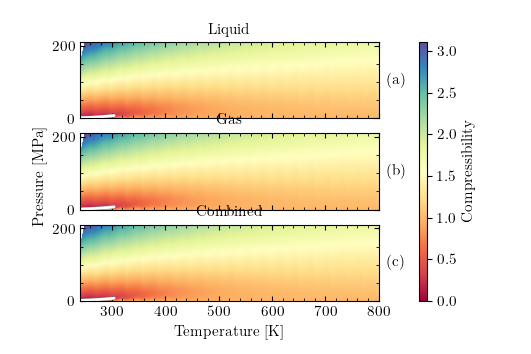

In [13]:
# data
x1, y1 = pxflash_data.prepare_temperature_pressure()
z1, z2 = pxflash_data.prepare_compressibility()

x2 = x1; y2 = y1;
x3 = x1; y3 = y1;

z3 = create_combined_pxflash_compressibilities(pxflash_data)

# plot
data_normal = [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]]
data_error = []
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_titles(axes, ["Liquid", "Gas", "Combined"])
plot.set_cbar_labels(cbars, ["Compressibility"])

## Compute NIST Coefficients

Temperature and pressure are inputs to the flash solve. An output of the solve is the compressibility.
The corrected volume is the target value to figure out.
These variables can be used to compute that.

In [14]:
def compute_singular_coefficients(temperature, pressure, compressibility, nist_data):

    nist_corrected_volume = compute_nist_corrected_volume(nist_data)
    
    volume_array = np.full(len(temperature), 0.0)
    for i in range(0, len(temperature)):
        volume_array[i] = real_gas_law.volume(temperature[i], pressure[i], compressibility[i])
    
    
    # corrected_volume = volume - c * sigma
    # sigma here is equal to 1, as its all CO2
    # see formulation of volume correction in fluid modelling documentation for more
    # thus c = volume - corrected_volume
    coefficients_via_nist = volume_array - nist_corrected_volume

    return coefficients_via_nist


### Define b equation of state definition

In [15]:
# Peng Robinson and Soave-Redlich-Kwong b definition
def b_i(omega, critical_temperature, critical_pressure):
    return (omega * real_gas_law.R * critical_temperature) / critical_pressure

# Peng Robinson omega b value
omega = 0.077796073903888457

t, p = pxflash_data.prepare_temperature_pressure()
b = np.full(len(t), b_i(omega, co2.critical_point[0], co2.critical_point[1]))

In [16]:
def generate_shift_s(pxflash_data, nist_data, bound = False, bound_lower = -1.0, bound_upper = 1.0):
    
    t, p = pxflash_data.prepare_temperature_pressure()
    
    # we use compressibility, z, because this comes from the equation of state solve
    # t, p, and z is information we have after the equation of state solve
    z = create_combined_pxflash_compressibilities(pxflash_data)
    
    coefficients_via_nist = compute_singular_coefficients(t, p, z, nist_data)
    shift_s = coefficients_via_nist / b
    
    if (bound == True):
        shift_s[np.where(shift_s > bound_upper)] = bound_upper 
        shift_s[np.where(shift_s < bound_lower)] = bound_lower

    return shift_s

Text(0.5, 1.0, 'Bounded')

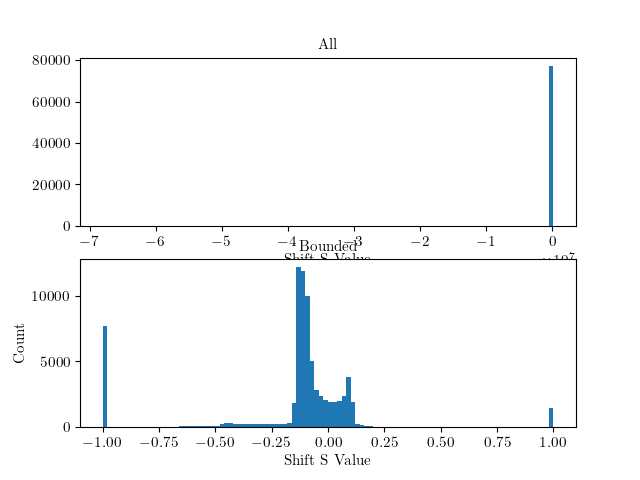

In [17]:
shift_s_unbounded = generate_shift_s(pxflash_data, nist_data)
shift_s_bound = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

fig, axes = plt.subplots(nrows=2)
ax1, ax2 = axes

ax = ax1
ax.hist(shift_s_unbounded, bins=100)
ax.set_xlabel("Shift S Value")
ax.set_title("All")

ax = ax2
ax.hist(shift_s_bound, bins=100)
ax.set_xlabel("Shift S Value")
ax.set_ylabel("Count")
ax.set_title("Gas")
ax.set_title("Bounded")

### Which points are modified when shift s in bounded?

[<matplotlib.collections.PathCollection object at 0x0000026A2F848550>, <matplotlib.collections.PathCollection object at 0x0000026A2F80E5F0>]


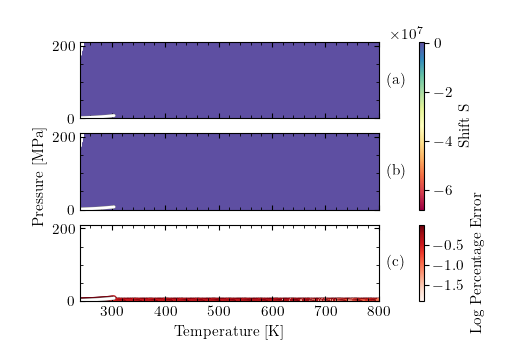

In [18]:
# data

x1, y1 = nist_data.prepare_temperature_pressure()
z1 = generate_shift_s(pxflash_data, nist_data)
z2 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# error
z3 = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x3, y3, z3, -2, np.max(z3)) 
# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
#plot.set_titles(axes, ["Unbounded", "Bounded", "Modified"])
plot.set_cbar_labels(cbars, ["Shift S", "Log Percentage Error"])

### A zoomed in error plot to show which points are modified of the bounded shift s

[]


Text(0.5, 1.0, 'Shift S')

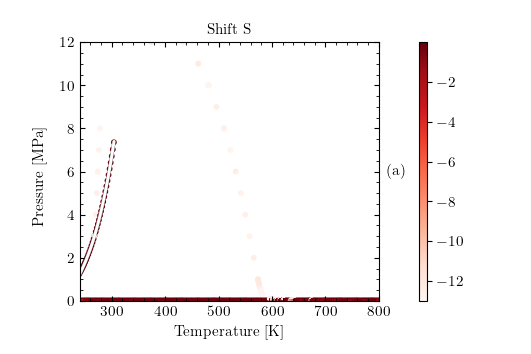

In [19]:
# data

x1, y1 = nist_data.prepare_temperature_pressure()
z1 = generate_shift_s(pxflash_data, nist_data)
z2 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# error
z3 = utility.compute_log_percentage_error(z1, z2)

indices = np.where(p < (co2.critical_point[1] * 2))
x3, y3, z3 = utility.bound_data_indices(x3, y3, z3, indices)
x3, y3, z3 = utility.bound_data(x3, y3, z3, -13, np.max(z3)) 

data_normal = []
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
ax = axes[0]
ax.set_title("Shift S")

### 3D plot of the bounded shift s values

Text(0.5, 0, 'Shift S')

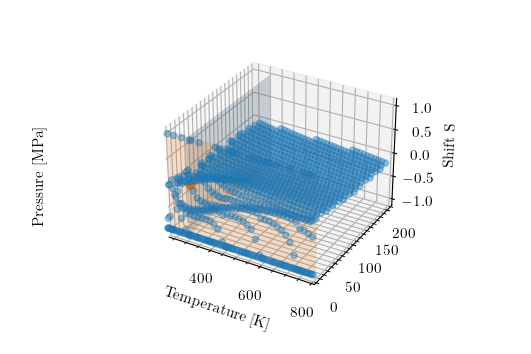

In [20]:
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)
sf = plot.scatter_3d(x1, y1, z1, step = 75)
ax = sf.axes[0]
ax.set_zlabel('Shift S')

### 2D plot of the bounded shift s values

Text(0.5, 1.0, 'Shift S')

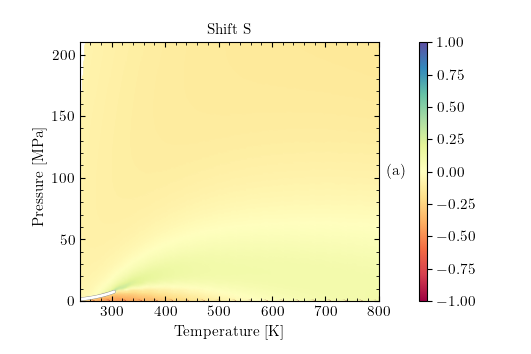

In [21]:
x1, y1 = pxflash_data.prepare_temperature_pressure()
z1 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

data_normal = [[x1, y1, z1]]
data_error = []
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
ax = axes[0]
ax.set_title("Shift S")

This is a complicated surface to fit, with a hill from the critical point of CO2.

# Forward Calculation
How good is calculation using coefficents computed from NIST data? 

Using the inputs temperature and pressure, and the compressbilities from the equation of state solve, and then the now NIST shift s values;
How do the corrected volumens and corrected compressbilities compare to the NIST database?

In [22]:
def forward_calculation(pxflash_data, nist_data):
    
    t, p = pxflash_data.prepare_temperature_pressure()
    shift_s = generate_shift_s(pxflash_data, nist_data)
    pxflash_compressibilities = create_combined_pxflash_compressibilities(pxflash_data)
    
    coefficients = np.full(len(t), 0.0)
    c_totals = np.full(len(t), 0.0)
    volumes = np.full(len(t), 0.0)
    new_volumes = np.full(len(t), 0.0)
    corrected_compressibilities = np.full(len(t), 0.0)

    for i in range(0, len(t)):

        coefficients[i] = shift_s[i] * b[i]
        c_totals[i] = coefficients[i] * 1
        volumes[i] = real_gas_law.volume(t[i], p[i], pxflash_compressibilities[i])

        new_volumes[i] = volumes[i] - c_totals[i]

        corrected_compressibilities[i] = real_gas_law.compressibility(t[i], p[i], new_volumes[i])
        
    return shift_s, coefficients, c_totals, volumes, new_volumes, corrected_compressibilities

### Compare forward calculation compressibilities using shift s and NIST compressibilities

[<matplotlib.collections.PathCollection object at 0x0000026A31DFB670>, <matplotlib.collections.PathCollection object at 0x0000026A31DB5B40>]


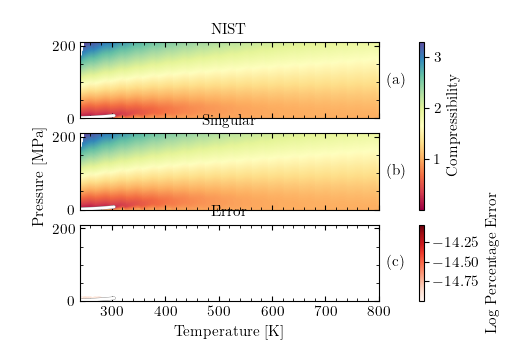

In [23]:
# data
x1, y1 = nist_data.prepare_temperature_pressure()
shift_s, coefficients, c_totals, volumes, new_volumes, corrected_compressibilities = forward_calculation(pxflash_data, nist_data)

z1 = compute_nist_corrected_compressibility(nist_data)
z2 = corrected_compressibilities

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# error
z3 = utility.compute_log_percentage_error(z1, z2)
x3, y3, z3 = utility.bound_data(x3, y3, z3, -15, np.max(z3)) 

# plot
data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_titles(axes, ["NIST", "Singular", "Error"])
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

# What to Fit
Investigation revealed the surface of the the shift s values is quite hard to fit to?
Also the volume at very low pressure has a huge gradient. Added to the dataset, by getting more pressure points and low pressures.

Now, look at fitting other surfaces to see if they may be easier to fit too.

### 2D and 3D plots of the NIST density, NIST compressibility, and NIST volume

D:\notes\development\_projects\pet_x_co2_issues\assets\plot.py:226: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Text(0.5, 0, 'Volume $\\left[ \\si{\\metre\\cubed} \\right]$')

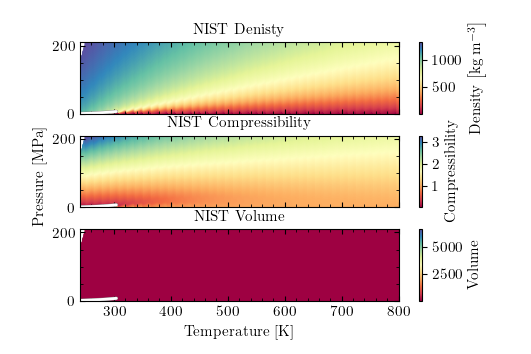

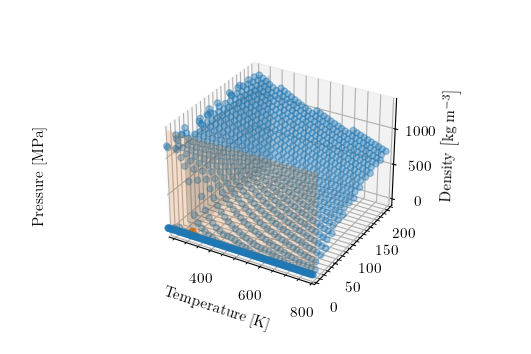

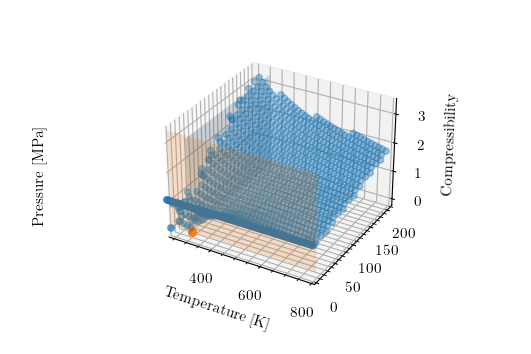

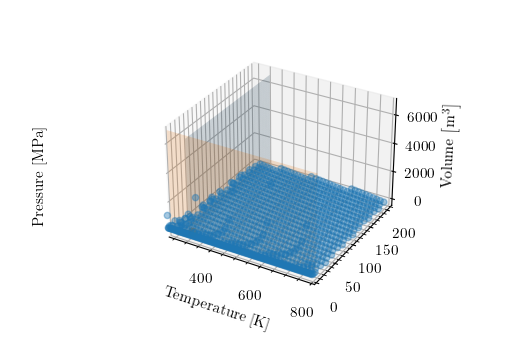

In [24]:
nist_data = import_data.NISTData("nist_data.csv")

# data
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()
z2 = compute_nist_corrected_compressibility(nist_data)
z3 = compute_nist_corrected_volume(nist_data)

x2 = x1; y2 = y1
x3 = x1; y3 = y1

# plot
sf = st.standard_figure(fig, axes, fig_params) # create standard_figure
data = [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]]
sf, cbars = plot.scatter_n_separate(data)
fig = sf.fig
axes = sf.axes
plot.set_titles(axes, ["NIST Denisty", "NIST Compressibility", "NIST Volume"])
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Compressibility", "Volume"])


sf = plot.scatter_3d(x1, y1, z1, step = 75)
ax = sf.axes[0]
ax.set_zlabel(plot.density_label(sf))

sf = plot.scatter_3d(x2, y2, z2, step = 75)
ax = sf.axes[0]
ax.set_zlabel('Compressibility')

sf = plot.scatter_3d(x3, y3, z3, step = 75)
ax = sf.axes[0]
ax.set_zlabel(plot.volume_label(sf))

## Fit Models

Model A and model B are two different python fitting algorithms. This section is a quick example of how to use them

### Model A

In [25]:
import itertools

def model_a_polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def model_a_polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

### Model B

In [26]:
# data = [x, y]
def model_b_func(data, a1, a2, a3, a4, a5):

    # extract data from the single list
    x1 = data[0]
    x2 = data[1]

    #f = a1*x1 + a2*x2 + a3
    #f =  np.sqrt(a1*x1*x1 + a2*x2*x2 + a3)
    f =  a1*x1*x1 + a2*x2*x2 + a3*x1 + a4*x2 + a5
    return f
        
def model_b_fit(func, data, z, initialParameters):

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, data, z, p0 = initialParameters)
    
    return fittedParameters

# to evaluate the function simply call
# calculated_points = func(data, *fittedParameters) 

### Helper Functions

### Error Report

error report for the quality of the fit

In [27]:
def basic_error(x):
    
    error = np.sum(np.power(10, x))
    
    return error

def basic_error_n(x):
    
    error = np.sum(np.power(10, x))
    
    error = error / len(x)
    
    return error

def error_report(x):
    
    print("Error report:")
    print('max log error: {:.5}'.format(np.max(x)))
    print("average log error: {:.5}".format(np.average(x)))
    print("min log error: {:.5}".format(np.min(x)))
    print("---")
    print("max error: {:.2%}".format(np.power(10, np.max(x))))
    print("average % error: {:.2%}".format(np.power(10, np.average(x))))
    print("min % error: {:.2%}".format(np.power(10, np.min(x))))
    print("---")
    print("errors <= 0.1%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) <= 0.001)[0]), len(x), (len(np.where(np.power(10, x) <= 0.001)[0]) / len(x))))
    print("errors < 1%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) < 0.01)[0]), len(x), (len(np.where(np.power(10, x) < 0.01)[0]) / len(x))))
    print("errors > 1%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) > 0.01)[0]), len(x), (len(np.where(np.power(10, x) > 0.01)[0]) / len(x))))
    print("errors > 5%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) > 0.05)[0]), len(x), (len(np.where(np.power(10, x) > 0.05)[0]) / len(x))))
    print("errors > 10%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) > 0.1)[0]), len(x), (len(np.where(np.power(10, x) > 0.1)[0]) / len(x))))
    print("errors > 50%: {} of {} points, which is {:.2%}".format(len(np.where(np.power(10, x) > 0.5)[0]), len(x), (len(np.where(np.power(10, x) > 0.5)[0]) / len(x))))
    
    print("Singular Error Score: {}".format(basic_error(x)))
    print("Average Singular Error Score: {}".format(basic_error_n(x)))
    
    return


### Simple example of using model a

C:\Users\ppatel\AppData\Local\Temp/ipykernel_59532/2665880351.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Error report:
max log error: -0.1521
average log error: -0.88437
min log error: -1.301
---
max error: 70.45%
average % error: 13.05%
min % error: 5.00%
---
errors <= 0.1%: 0 of 32101 points, which is 0.00%
errors < 1%: 0 of 32101 points, which is 0.00%
errors > 1%: 32101 of 32101 points, which is 100.00%
errors > 5%: 32101 of 32101 points, which is 100.00%
errors > 10%: 21810 of 32101 points, which is 67.94%
errors > 50%: 253 of 32101 points, which is 0.79%
Singular Error Score: 4786.960486401298
Average Singular Error Score: 0.14912184936298864


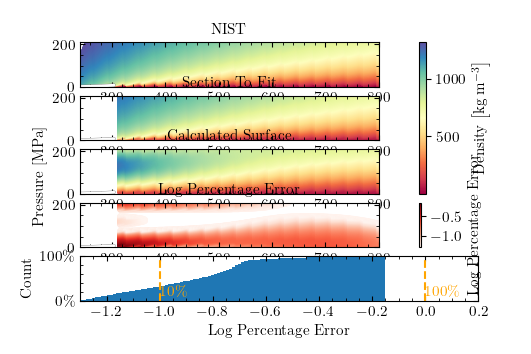

In [28]:
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

#indices = np.where(z1 == z1) # all
#indices = np.where((x1 > co2.critical_point[0]) & (y1 > co2.critical_point[1]))
indices = np.where((t > co2.critical_point[0] + 10) & (p > co2.critical_point[1]))
x2, y2, z2 = utility.bound_data_indices(x1, y1, z1, indices)

# model, fit and evaluate
model = model_a_polyfit2d(x2, y2, z2, order = 2)

# calculated_points
x3 = x2; y3 = y2
z3 = model_a_polyval2d(x3, y3, model)

# error
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
#x4, y4, z4 = utility.bound_data(x4, y4, z4, np.min(z4), np.max(z4)) # 5%
x4, y4, z4 = utility.bound_data(x4, y4, z4, -1.30102999, np.max(z4)) # 5%

error_report(z4)
    
# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Log Percentage Error"])


### Simple example of using model b

Error report:
max log error: -0.54688
average log error: -1.9213
min log error: -6.027
---
max error: 28.39%
average % error: 1.20%
min % error: 0.00%
---
errors <= 0.1%: 285 of 8927 points, which is 3.19%
errors < 1%: 3133 of 8927 points, which is 35.10%
errors > 1%: 5794 of 8927 points, which is 64.90%
errors > 5%: 844 of 8927 points, which is 9.45%
errors > 10%: 196 of 8927 points, which is 2.20%
errors > 50%: 0 of 8927 points, which is 0.00%
Singular Error Score: 185.49486063082827
Average Singular Error Score: 0.020779081508998352


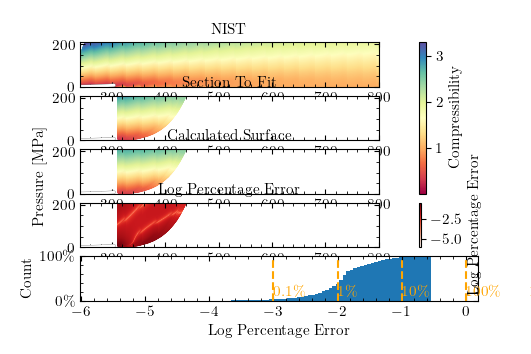

In [29]:
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_compressibility(nist_data)

indices = np.where((t > co2.critical_point[0] + 10) & (p > co2.vapourisation_condensation_pressure(t) * 0.9))
x2, y2, z2 = utility.bound_data_indices(x1, y1, z1, indices)

# model, fit and evaluate
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2], z2, initialParameters)

# calculated_points
x3 = x2; y3 = y2
z3 = model_b_func([x3, y3], *model)

# error
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
x4, y4, z4 = utility.bound_data(x4, y4, z4, np.min(z4), np.max(z4))
error_report(z4)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, ["Compressibility", "Log Percentage Error"])

## Playground - Fit to Corrected Volume
Playing around with trying to fit a surface to the corrected volume

### Visualise corrected volume surface
and bound values to see other details

Text(0.5, 0, 'Volume $\\left[ \\si{\\metre\\cubed} \\right]$')

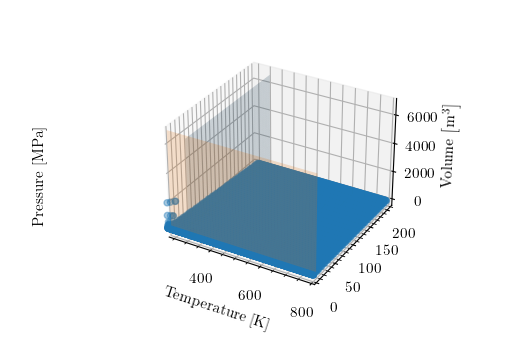

In [30]:
nist_data = import_data.NISTData("nist_data.csv")

# data
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_volume(nist_data)
#z1 = nist_data.prepare_volume()

#indices = np.where(y1 >= 101325)
#x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

#indices = np.where(z1 <= 0.001)
#x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

#indices = np.where(z1 <= 0.0001)
#x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

sf = plot.scatter_3d(x1, y1, z1, step = 8)
ax = sf.axes[0]
ax.set_zlabel(plot.volume_label(sf))

### Fit using Pressure and Temperature

The real gas law is `PV = ZnRT`.
The volume rearranged is `V = ZnRT / P`

The fit using only pressure and temperature could be a combination of `T` and `P`

In [31]:
# data = [x, y]
def model_b_func(data, a1, a2, a3, a4, a5, a6, a7):

    # extract data from the single list
    x1 = data[0]
    x2 = data[1]

    # form to try estimate the volume
    # V = a1 T^2 / P^2 + a2 T / P + a3 T + a4 P + a5
    f =  a1*real_gas_law.R*real_gas_law.R*(x1*x1)/(x2*x2) + a2*real_gas_law.R*(x1/x2) + a3*x1 + a4*x2 + a5 \
            + a6*real_gas_law.R*real_gas_law.R*real_gas_law.R*(x1*x1*x1)/(x2*x2*x2) \
            + a7*real_gas_law.R*(1/x2)
    return f
        
def model_b_fit(func, data, z, initialParameters):

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, data, z, p0 = initialParameters)
    
    return fittedParameters

# to evaluate the function simply call
# calculated_points = model_b_func(data, *fittedParameters) 

Error report:
max log error: 0.75645
average log error: -1.2761
min log error: -5.2042
---
max error: 570.76%
average % error: 5.30%
min % error: 0.00%
---
errors <= 0.1%: 246 of 30810 points, which is 0.80%
errors < 1%: 2657 of 30810 points, which is 8.62%
errors > 1%: 28153 of 30810 points, which is 91.38%
errors > 5%: 16207 of 30810 points, which is 52.60%
errors > 10%: 8992 of 30810 points, which is 29.19%
errors > 50%: 852 of 30810 points, which is 2.77%
Singular Error Score: 3603.963732803491
Average Singular Error Score: 0.11697383099005164
model constants: [-7.76184611e+03  1.46432662e+02 -7.64920968e-04  9.67003082e-09
  7.95754088e-01  1.16394673e+05 -4.11717837e+03]


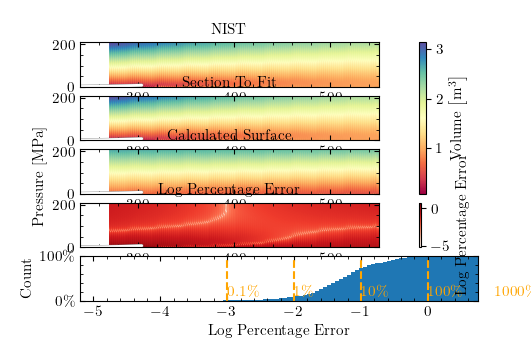

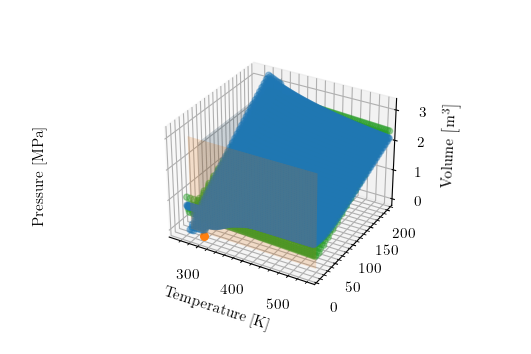

In [32]:
# Input data, t and p; and target value to fit, v
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_volume(nist_data)
z1 = nist_data.prepare_volume()
z1 = compute_nist_corrected_compressibility(nist_data)

# Bound the input data to certain temperatures and pressures
indices = np.where((x1 >= 273.15) & (x1 <= 550) & (y1 >= 101325))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  

# Bound the data to which to perform the fit on

# case: all
#indices = np.where(z1 == z1)
#indices = np.where((x1 > co2.critical_point[0]) & (y1 > co2.critical_point[1]) & (y1 < 70e6))
#indices = np.where((x1 > co2.critical_point[0]) & (y1 > co2.critical_point[1]) & (y1 < 70e6))
#indices = np.where((x1 > co2.critical_point[0]) & (y1 < 70e6))

# case: limit upper pressure
#indices = np.where((y1 < 200e6))

# case: avoid points around co2.vapourisation_condensation_pressure line
indices = np.where((x1 > co2.critical_point[0]))
indices_b = np.where((x1 < co2.critical_point[0]) & (y1 > co2.critical_point[1] + 3e7))
indices_c = np.where((y1 < co2.vapourisation_condensation_pressure(x1) - 0.5e6) & (x1 < co2.critical_point[0]))
indices_d = np.where((y1 > co2.vapourisation_condensation_pressure(x1) + 0.5e6) & (x1 < co2.critical_point[0]) & (y1 <= 50e6))
indices = np.append(indices, indices_b)
indices = np.append(indices, indices_c)
indices = np.append(indices, indices_d)
indices = np.unique(indices)

x2 = x1; y2 = y1; z2 = z1
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  


# model, fit and evaluate
#initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model = model_b_fit(model_b_func, [x2, y2], z2, initialParameters)

# calculated points using fit
x3 = x2; y3 = y2
z3 = model_b_func([x3, y3], *model)

# error between data and calculated points
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# bound the errors for plotting
min_error = np.min(z4) # or np.min(z4), np.log10(0.05)
max_error = np.max(z4)
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.volume_label(sf), "Log Percentage Error"])

sf = plot.scatter_3d(x2, y2, z2, step = 6)
n = len(x3)
step = 12
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.volume_label(sf))

print("model constants:", model)

### Using Pressure, Temperature and (non-corrected) Compressibility

The real gas law is `PV = ZnRT`.
The volume rearranged is `V = ZnRT / P`

The fit using only pressure and temperature could be a combination of `T`, `P`, and `Z`

In [33]:
# data = [x, y, k] = [temperature, pressure, (non-corrected) compressibility]
def model_b_func(data, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10):

    # extract data from the single list
    x1 = data[0]
    x2 = data[1]
    x3 = data[2]

    # form to try estimate the volume
    f = a1*real_gas_law.R*real_gas_law.R*(x1*x1)/(x2*x2) + a2*real_gas_law.R*(x1/x2) + a3*real_gas_law.R*x1 + a4*real_gas_law.R*x2 + a5*real_gas_law.R \
        + a6*np.power(real_gas_law.R*x3*(x1/x2), 2.0) + a7*real_gas_law.R*x3*(x1/x2) + a8*real_gas_law.R*x1*x3 + a9*real_gas_law.R*x2*x3 + a10*real_gas_law.R*x3
    
    return f
        
def model_b_fit(func, data, z, initialParameters):

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, data, z, p0 = initialParameters, maxfev=5000)
    
    return fittedParameters

# to evaluate the function simply call
# calculated_points = func(data, *fittedParameters) 

In [34]:
# data = [x, y, k] = [temperature, pressure, (non-corrected) compressibility]
def model_b_func(data, a6, a7, a8, a9, a10):

    # extract data from the single list
    x1 = data[0]
    x2 = data[1]
    x3 = data[2]

    # form to try estimate the volume
    f = a6*np.power(real_gas_law.R*x3*(x1/x2), 2.0) + a7*real_gas_law.R*x3*(x1/x2) + a8*real_gas_law.R*x1*x3 + a9*real_gas_law.R*x2*x3 + a10*real_gas_law.R*x3
    return f
        
def model_b_fit(func, data, z, initialParameters):

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, data, z, p0 = initialParameters, maxfev=5000)
    
    return fittedParameters

# to evaluate the function simply call
# calculated_points = func(data, *fittedParameters) 

Error report:
max log error: -0.78727
average log error: -2.0161
min log error: -7.894
---
max error: 16.32%
average % error: 0.96%
min % error: 0.00%
---
errors <= 0.1%: 4077 of 58560 points, which is 6.96%
errors < 1%: 21705 of 58560 points, which is 37.06%
errors > 1%: 36855 of 58560 points, which is 62.94%
errors > 5%: 1947 of 58560 points, which is 3.32%
errors > 10%: 280 of 58560 points, which is 0.48%
errors > 50%: 0 of 58560 points, which is 0.00%
Singular Error Score: 954.3316263993383
Average Singular Error Score: 0.016296646625671762
model constants: [-5.36193082e-03  1.00028136e+00 -7.68129147e-11  1.33729751e-15
  2.10416273e-08]


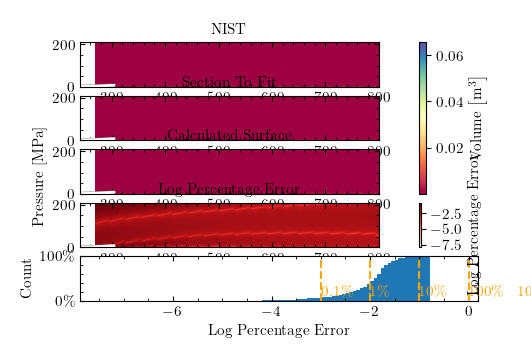

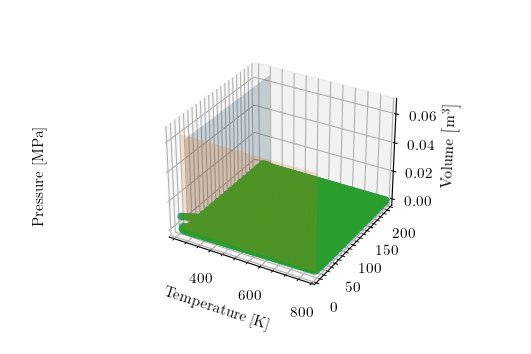

In [35]:
# Input data, t, p, z; and target value to fit, v
nist_data = import_data.NISTData('nist_data.csv')
pxflash_data = import_data.PxFlashData('pxflash_data.csv')

x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)
z1 = compute_nist_corrected_volume(nist_data)

# Bound the input data to certain temperatures and pressures
indices = np.where((x1 >= pressure_temperature_constants.zero_celsius) & (x1 <= 800) & (y1 >= pressure_temperature_constants.one_atmosphere))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
k1 = k1[indices]

# Bound the data to which to perform the fit on

# case: all
#indices = np.where(z1 == z1)
#indices = np.where((x1 > co2.critical_point[0]) & (y1 > co2.critical_point[1]) & (y1 < 70e6))
#indices = np.where((x1 > co2.critical_point[0]) & (y1 > co2.critical_point[1]) & (y1 < 70e6))
#indices = np.where((x1 > co2.critical_point[0]) & (y1 < 70e6))

# case: limit upper pressure
#indices = np.where((y1 < 200e6))

# case: avoid points around co2.vapourisation_condensation_pressure line
indices = np.where((x1 > co2.critical_point[0]))
indices_b = np.where((x1 < co2.critical_point[0]) & (y1 > co2.critical_point[1] + 3e7))
indices_c = np.where((y1 < co2.vapourisation_condensation_pressure(x1) - 0.5e6) & (x1 < co2.critical_point[0]))
indices_d = np.where((y1 > co2.vapourisation_condensation_pressure(x1) + 0.5e6) & (x1 < co2.critical_point[0]) & (y1 <= 50e6))
indices = np.append(indices, indices_b)
indices = np.append(indices, indices_c)
indices = np.append(indices, indices_d)
indices = np.unique(indices)

x2 = x1; y2 = y1; k2 = k1; z2 = z1; 
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  
k2 = k2[indices]


# model, fit and evaluate
#initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2, k2], z2, initialParameters)

# calculated points using fit
x3 = x2; y3 = y2
k3 = k2;
z3 = model_b_func([x3, y3, k3], *model)

# error between data and calculated points
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# bound the errors for plotting
min_error = np.min(z4) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z4)
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.volume_label(sf), "Log Percentage Error"])

step = 12
sf = plot.scatter_3d(x2, y2, z2, step = step)
n = len(x3)
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.volume_label(sf))

print("model constants:", model)

### Visual where some of the errors are

[]


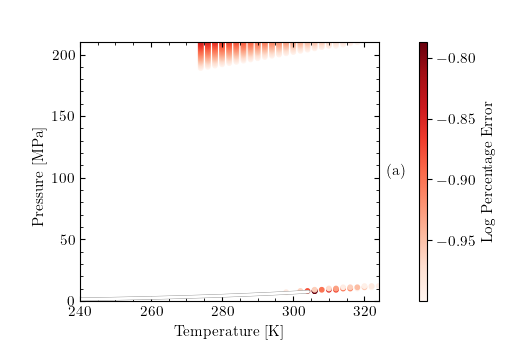

In [36]:
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)

min_error = np.log10(0.10) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z4)
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

sf, cbars = plot.scatter_normals_errors([], [[x4, y4, z4]])
plot.set_cbar_labels(cbars, ["Log Percentage Error"])

### What are these very high points?

Text(0.5, 0, 'Volume $\\left[ \\si{\\metre\\cubed} \\right]$')

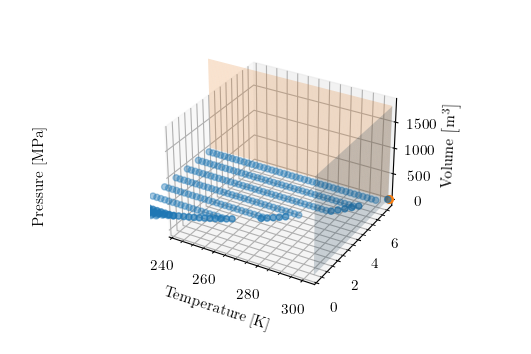

In [37]:
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_volume(nist_data)

indices = np.where((y1 > co2.vapourisation_condensation_pressure(x1)) & (y1 < co2.critical_point[1]) & (x1 <  co2.critical_point[0]))
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  

sf = plot.scatter_3d(x1, y1, z1, step = 1)
ax = sf.axes[0]
ax.set_zlabel(plot.volume_label(sf))

So if you want a smooth profile, pressure should be around?

10.0


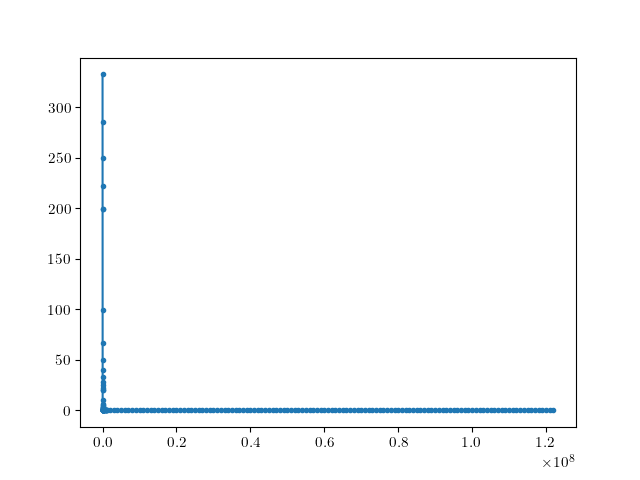

In [38]:


x1, y1 = nist_data.prepare_temperature_pressure()
z1 = compute_nist_corrected_volume(nist_data)

indices = np.where((x1 == 240) & (y1 >= y1[5]))
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
print(y1[5])

fig, ax = plt.subplots()
ax.plot(y1, z1, ".-")

### Fit the points within the gas region under vapourisation_condensation line

In [39]:
nist_data = import_data.NISTData('nist_data.csv')
pxflash_data = import_data.PxFlashData('pxflash_data.csv')

x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)
z1 = compute_nist_corrected_volume(nist_data)

# Bound the input data to certain temperatures and pressures
indices = np.where((x1 >= 273.15) & (x1 <= 550) & (y1 >= 101325))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
k1 = k1[indices]

# Bound the data to which to perform the fit on

# Gas under the vapourisation_condensation line
indices = np.where((y1 < co2.vapourisation_condensation_pressure(x1) * 0.8 ) & (x1 < co2.critical_point[0]))
x2 = x1; y2 = y1; z2 = z1; k2 = k1;
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  
k2 = k2[indices]


# model, fit and evaluate
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2, k2], z2, initialParameters)

# calculated points using fit
x3 = x2; y3 = y2
k3 = k2;
z3 = model_b_func([x3, y3, k3], *model)

# error between data and calculated points
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# bound the errors for plotting
min_error = np.min(z4) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.volume_label(sf), "Log Percentage Error"])

sf = plot.scatter_3d(x2, y2, z2, step = 6)
n = len(x3)
step = 1
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.volume_label(sf))

TypeError: model_b_func() takes 6 positional arguments but 11 were given

### Fit the points within the liquid region just above vapourisation_condensation line

In [ ]:
# Input data, t, p, z; and target value to fit, v
x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)
z1 = compute_nist_corrected_volume(nist_data)

# Bound the input data to certain temperatures and pressures
indices = np.where((x1 >= 273.15) & (x1 <= 550) & (y1 >= 101325))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
k1 = k1[indices]

# Bound the data to which to perform the fit on

# liquid section
indices = np.where((y1 > co2.vapourisation_condensation_pressure(x1) + 0.5e6) & (x1 < co2.critical_point[0]) & (y1 <= co2.critical_point[1]))
x2 = x1; y2 = y1; z2 = z1; k2 = k1;
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  
k2 = k2[indices]

# model, fit and evaluate
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2, k2], z2, initialParameters)

# calculated points using fit
x3 = x2; y3 = y2
k3 = k2;
z3 = model_b_func([x3, y3, k3], *model)

# error between data and calculated points
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# bound the errors for plotting
min_error = np.min(z4) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.volume_label(sf), "Log Percentage Error"])

sf = plot.scatter_3d(x2, y2, z2, step = 6)
n = len(x3)
step = 1
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.volume_label(sf))

### Fit the points around the vapourisation_condensation line

In [ ]:
# Input data, t, p, z; and target value to fit, v
nist_data = import_data.NISTData('nist_data.csv')
pxflash_data = import_data.PxFlashData('pxflash_data.csv')

x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)
z1 = compute_nist_corrected_volume(nist_data)

# Bound the input data to certain temperatures and pressures
indices = np.where((x1 <= 550) & (y1 >= 101325))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
k1 = k1[indices]

# Bound the data to which to perform the fit on

# around the line
indices = np.where((y1 < co2.vapourisation_condensation_pressure(x1) + 1e4) & (y1 >= co2.vapourisation_condensation_pressure(x1)) & (x1 < 280))
x2 = x1; y2 = y1; z2 = z1; k2 = k1;
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  
k2 = k2[indices]

# model, fit and evaluate
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2, k2], z2, initialParameters)

# calculated_points
x3 = x2; y3 = y2
k3 = k2;
z3 = model_b_func([x3, y3, k3], *model)

# error
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# bound the errors for plotting
min_error = np.min(z4) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.volume_label(sf), "Log Percentage Error"])

sf = plot.scatter_3d(x2, y2, z2, step = 6)
n = len(x3)
step = 1
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.volume_label(sf))

### See error of fitted model over a larger range of pressure and temperature
How does a model fitted to a smaller range of data fair when being used on a larger range of pressure and temperature values

In [ ]:
# Input data, t, p, z; and target value to fit, v
nist_data = import_data.NISTData('nist_data.csv')
pxflash_data = import_data.PxFlashData('pxflash_data.csv')

x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)
z1 = compute_nist_corrected_volume(nist_data)

# calculated_points
x3 = x1; y3 = y1
k3 = k1;
z3 = model_b_func([x3, y3, k3], *model)

x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z1, z3)

min_error = np.log10(0.10) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z4)
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

sf, cbars = plot.scatter_normals_errors([], [[x4, y4, z4]])
plot.set_cbar_labels(cbars, ["Log Percentage Error"])

## Playground - Fit to Density
Playing around with trying to fit a surface to the density

### Visualise corrected volume surface
and bound values to see other details

In [ ]:
nist_data = import_data.NISTData("nist_data.csv")

# data
x1, y1 = nist_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

indices = np.where(y1 >= 101325)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

#indices = np.where(z1 <= 0.001)
#x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

#indices = np.where(z1 <= 0.0001)
#x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

sf = plot.scatter_3d(x1, y1, z1, step = 8)
ax = sf.axes[0]
ax.set_zlabel(plot.density_label(sf))

### Using Pressure, Temperature and (non-corrected) Compressibility

`density = mass / volume`

`number of moles = mass / molecular weight`

so 
The real gas law is `PV = ZnRT`.

`PV = Z ( d / V * MW ) RT`

`d = P MW / ZRT`

The fit using only pressure and temperature could be a combination of `T`, `P`, and `Z`

In [ ]:
# data = [x, y, k] = [temperature, pressure, (non-corrected) compressibility
def model_b_func(data, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16):

    # extract data from the single list
    x1 = data[0]
    x2 = data[1]
    x3 = data[2]

    # form to try estimate the volume
    f = a1*(x2*molecular_weight_kg_per_mol / x3*real_gas_law.R*x1) + a2*np.power(x2*molecular_weight_kg_per_mol / x3*real_gas_law.R*x1, 2.0) \
        + a3*molecular_weight_kg_per_mol / real_gas_law.R + a4 \
        + a5*x1*x1 + a6*x1 \
        + a7*x2*x2 + a8*x2 \
        + a9*x3*x3 + a10*x3 \
        + a11*x1*x2*x3 + a12*x1*x2 + a13*x2*x3 \
        + a14*np.power(x1*x2*x3, 2.0) + a15*np.power(x1*x2, 2.0) + a16*np.power(x2*x3, 2.0)

    return f
        
def model_b_fit(func, data, z, initialParameters):

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, data, z, p0 = initialParameters, maxfev=5000)
    
    return fittedParameters

# to evaluate the function simply call
# calculated_points = func(data, *fittedParameters) 

In [ ]:
nist_data = import_data.NISTData('nist_data.csv')
x1, y1 = nist_data.prepare_temperature_pressure()
k1 = create_combined_pxflash_compressibilities(pxflash_data)

z1 = nist_data.prepare_density()


# Bound the input data to certain temperatures and pressures
indices = np.where((x1 >= 273.15) & (x1 <= 550) & (y1 >= 101325))
indices = np.unique(indices)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)  
k1 = k1[indices]

# Bound the data to which to perform the fit on

# case: avoid points around co2.vapourisation_condensation_pressure line
indices = np.where((x1 > co2.critical_point[0]))
indices_b = np.where((x1 < co2.critical_point[0]) & (y1 > co2.critical_point[1] + 3e7))
indices_c = np.where((y1 < co2.vapourisation_condensation_pressure(x1) - 0.5e6) & (x1 < co2.critical_point[0]))
indices_d = np.where((y1 > co2.vapourisation_condensation_pressure(x1) + 0.5e6) & (x1 < co2.critical_point[0]) & (y1 <= 50e6))
indices = np.append(indices, indices_b)
indices = np.append(indices, indices_c)
indices = np.append(indices, indices_d)
indices = np.unique(indices)

x2 = x1; y2 = y1; z2 = z1; k2 = k1;
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)  
k2 = k2[indices]


# model, fit and evaluate
initialParameters = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # these are the same as scipy default values in this example
model = model_b_fit(model_b_func, [x2, y2, k2], z2, initialParameters)

# calculated_points
x3 = x2; y3 = y2
k3 = k2;
z3 = model_b_func([x3, y3, k3], *model)

# error
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)
error_report(z4)

# what errors to plot
min_error = np.min(z4) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)


# plot
sf, cbars = plot.fit_analysis(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4)
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Log Percentage Error"])

sf = plot.scatter_3d(x2, y2, z2, step = 6)
n = len(x3)
step = 12
ax = sf.axes[0]
ax.scatter(x3[1:n:step], y3[1:n:step], z3[1:n:step], alpha=0.4)
ax.set_zlabel(plot.density_label(sf))

### Visual where some of the errors are

In [ ]:
x4 = x3; y4 = y3
z4 = utility.compute_log_percentage_error(z2, z3)

min_error = np.log10(0.10) # np.min(z4), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z4)
x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)

sf, cbars = plot.scatter_normals_errors([], [[x4, y4, z4]])
plot.set_cbar_labels(cbars, ["Log Percentage Error"])

## Compute Fitted Density

### Compute Shift Coefficient 
Using the fitted function to back calculate the shift cofficient

In [ ]:
# ! fit function is not passed in
def compute_shift_s_from_fit(pxflash_data, evaluation_function, model_parameters):
    
    temperature, pressure = pxflash_data.prepare_temperature_pressure()

    p_liquid, p_gas = pxflash_data.prepare_compressibility()
    compressibility = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)
    
    volume = real_gas_law.volume(temperature, pressure, compressibility)

    corrected_volume = evaluation_function([temperature, pressure, compressibility], *model_parameters) 

    c_total = volume - corrected_volume
    shift_s = c_total / b
    
    return shift_s

## Compare Shift S values from pxflash, NIST data, and NIST fit

In [ ]:
# first started using the corrected volume main region fit 

x1, y1 = pxflash_data.prepare_temperature_pressure()

p_liquid, p_gas = pxflash_data.prepare_coefficients()
pxflash_shift_s = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)
z1 = pxflash_shift_s

x2 = x1; y2 = y1
z2 = compute_shift_s_from_fit(pxflash_data, model_b_func, model)
z2 = utility.bound_array(z2, -1.0, 1.0)

x3 = x1; y3 = y1
z3 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

x4 = x1; y4 = y1
z4 = utility.compute_log_percentage_error(z1, z2)

x5 = x1; y5 = y1
z5 = utility.compute_log_percentage_error(z2, z3)

data_normal = [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]]
data_error = [[x4, y4, z4], [x5, y5, z5]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_cbar_labels(cbars, ["Shift S", "Log Percentage Error"])
plot.set_titles(axes, ["Pxflash Shift S", "Shift S from Fit", "Shift S from Data", "Error in pxflash and fit", "Error in fit and from data", "Log Percentage Error"])

### Compare shift S values of from the model of the NIST data, and the calculated NIST shift s values

In [ ]:
fig, axes = plt.subplots(nrows=2)
ax1, ax2 = axes

ax = ax1
ax.hist(z2, bins=100)
ax.set_xlabel("Shift S Value from fit")
ax.set_title("From fit")

ax = ax2
ax.hist(z3, bins=100)
ax.set_xlabel("Shift S Value")
ax.set_ylabel("Count")
ax.set_title("From data")

### Where are all these minus ones

In [ ]:
x1, y1 = pxflash_data.prepare_temperature_pressure()

p_liquid, p_gas = pxflash_data.prepare_coefficients()
pxflash_shift_s = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)
z1 = compute_shift_s_from_fit(pxflash_data, model_b_func, model)
z1 = utility.bound_array(z1, -1.0, 1.0)

indices = np.where(z1 == -1.0)
x1, y1, z1 = utility.bound_data_indices(x1, y1, z1, indices)

x2, y2 = pxflash_data.prepare_temperature_pressure()
z2 = generate_shift_s(pxflash_data, nist_data, bound = True, bound_lower = -1.0, bound_upper = 1.0)

indices = np.where(z2 == -1.0)
x2, y2, z2 = utility.bound_data_indices(x2, y2, z2, indices)

data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = []
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_cbar_labels(cbars, ["Shift S"])
plot.set_titles(axes, ["from Fit", "from data"])

### Compute Density
Use the back-calculated shift cofficients, to now compute the density

In [ ]:
def compute_density_from_fit(pxflash_data, evaluation_function, model_parameters):

    # get data
    temperature, pressure = pxflash_data.prepare_temperature_pressure()

    p_liquid, p_gas = pxflash_data.prepare_volume()
    volume = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)
    volume = volume * convert_pxflash_volume_to_real_volume

    p_liquid, p_gas = pxflash_data.prepare_compressibility()
    pxflash_compressibility = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)

    
    # compute
    shift_s = compute_shift_s_from_fit(pxflash_data, evaluation_function, model_parameters)
    
    c_total = shift_s * b
    corrected_volume = volume - c_total
    corrected_compressibility = real_gas_law.compressibility(temperature, pressure, corrected_volume)
    pxflash_density = real_gas_law.density(temperature, pressure, molecular_weight_kg_per_mol, corrected_compressibility)
    
    return pxflash_density

## Compare NIST density and density calculated from the model

In [ ]:
# first started using the corrected volume main region fit 

x1, y1 = pxflash_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

x2 = x1; y2 = y1
z2 = compute_density_from_fit(pxflash_data, model_b_func, model)

x3 = x1; y3 = y1
z3 = utility.compute_log_percentage_error(z1, z2)

#indices = np.where(y3 >= 101325)
#x3, y3, z3 = utility.bound_data_indices(x3, y3, z3, indices)

# bound the errors for plotting
min_error = np.min(z3) # np.min(3), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z3)
x3, y3, z3 = utility.bound_data(x3, y3, z3, min_error, max_error)
error_report(z3)

data_normal = [[x1, y1, z1], [x2, y2, z2]]
data_error = [[x3, y3, z3]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Log Percentage Error"])
plot.set_titles(axes, ["NIST Density", "Density from Fit", "Log Percentage Error"])

### Any definitely wrong densities?

In [ ]:
x1, y1 = pxflash_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

x2 = x1; y2 = y1
z2 = compute_density_from_fit(pxflash_data, model_b_func, model)

indices = np.where(z2 < 0.0)
print(x2[indices])
print(y2[indices])
print(z2[indices])

### More Error Plots

In [ ]:
x3 = x1; y3 = y1
z3 = utility.compute_log_percentage_error(z1, z2)

min_error = np.log10(0.01) # np.min(3), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max(z3)
x3, y3, z3 = utility.bound_data(x3, y3, z3, min_error, max_error)
error_report(z3)

sf, cbars = plot.scatter_normals_errors([], [[x3, y3, z3]])
plot.set_cbar_labels(cbars, ["Log Percentage Error"])

fig, ax = plt.subplots()
plot.error_histogram(ax, z3)

### How does it compare to pxflash density?

In [ ]:
x1, y1 = pxflash_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

x2 = x1; y2 = y1
z2 = compute_density_from_fit(pxflash_data, model_b_func, model)

x3 = x1; y3 = y1
p_liquid, p_gas = pxflash_data.prepare_density()
z3 = create_combined_pxflash_property(pxflash_data, p_liquid, p_gas)

x4 = x1; y4 = y1
z4 = utility.compute_log_percentage_error(z1, z2)
x5 = x1; y5 = y1
z5 = utility.compute_log_percentage_error(z1, z3)

min_error = np.log10(0.001) # np.min(3), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max([np.max(z4), np.max(z5)])

x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)
x5, y5, z5 = utility.bound_data(x5, y5, z5, min_error, max_error)

data_normal = [[x1, y1, z1]]
data_error = [[x4, y4, z4], [x5, y5, z5]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Log Percentage Error"])
plot.set_titles(axes, ["NIST Density", "Error on Fit Model", "Error on Pxflash"])

## How about a model with fewer terms?

In [ ]:
reduced_model = np.copy(model)
reduced_model[3] = 0.0
reduced_model[8] = 0.0

In [ ]:
x1, y1 = pxflash_data.prepare_temperature_pressure()
z1 = nist_data.prepare_density()

x2 = x1; y2 = y1
z2 = compute_density_from_fit(pxflash_data, model_b_func, model)

x3 = x1; y3 = y1
p_liquid, p_gas = pxflash_data.prepare_density()
z3 = compute_density_from_fit(pxflash_data, model_b_func, reduced_model)

x4 = x1; y4 = y1
z4 = utility.compute_log_percentage_error(z1, z2)
x5 = x1; y5 = y1
z5 = utility.compute_log_percentage_error(z1, z3)

min_error = np.log10(0.001) # np.min(3), np.log10(0.05), np.log10(0.01), -1.0,  0.0
max_error = np.max([np.max(z4), np.max(z5)])

x4, y4, z4 = utility.bound_data(x4, y4, z4, min_error, max_error)
x5, y5, z5 = utility.bound_data(x5, y5, z5, min_error, max_error)

data_normal = [[x1, y1, z1]]
data_error = [[x4, y4, z4], [x5, y5, z5]]
sf, cbars = plot.scatter_normals_errors(data_normal, data_error)
fig = sf.fig
axes = sf.axes
plot.set_cbar_labels(cbars, [plot.density_label(sf), "Log Percentage Error"])
plot.set_titles(axes, ["NIST Density", "Error on Full Fit Model", "Error on Reduced Model"])